In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np                                                              
import pandas as pd      
import geopandas as gpd

from libpysal.weights import Queen
from splot.esda import plot_moran
from esda.moran import Moran
import spreg

In [2]:
import xgboost
import shap
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
from libpysal.weights import Queen

from splot.esda import plot_moran
from esda.moran import Moran

import spreg

In [4]:
def plot_1(b,title,vmin=None,vmax=None):
    #plt.figure(figsize=(6, 4), dpi=80)
    #plt.tight_layout()
    plt.imshow(b.reshape(size,size),vmin=vmin,vmax=vmax)
    plt.title(title,fontsize=13)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([]) 

In [5]:
size=50

In [6]:
np.random.seed(111)
X1 = np.random.uniform(-1.5,1.5,size*size)
X2 = np.random.uniform(-1.5,1.5,size*size)

err = np.random.randn(size*size)

X = np.vstack([X1,X2]).T
u = np.array([np.linspace(0,size-1,num=size)]*size).reshape(-1)
v = np.array([np.linspace(0,size-1,num=size)]*size).T.reshape(-1)
coords = list(zip(u,v))

In [7]:
df = pd.DataFrame(coords,columns=['x','y'])

In [8]:
gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df['x'], df['y']))


In [9]:
from libpysal.weights import KNN

w = KNN.from_dataframe(gdf,k=50)
w.transform = 'R'

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


In [10]:
b1=2
b2=1

In [11]:
ro = 0.8
y = b1*X1 +b2*X2 + err

IW = np.linalg.inv(np.identity(size*size) - ro*w.full()[0])

y = IW.dot(y)

lag = w.full()[0].dot(y)

#y = w.full()[0].dot(y)*2 + b1*X1 +b2*X2 + err

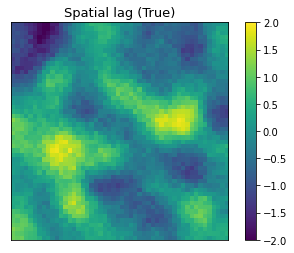

In [12]:
plot_1(lag, r'Spatial lag (True)',vmin=-2,vmax=2)

In [13]:
slm = spreg.ML_Lag(y, X, w=w, name_y='y', name_x=['X1','X2'])
print(slm.summary)

Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :           y                Number of Observations:        2500
Mean dependent var  :      0.0459                Number of Variables   :           4
S.D. dependent var  :      2.3140                Degrees of Freedom    :        2496
Pseudo R-squared    :      0.8114
Spatial Pseudo R-squared:  0.7859
Sigma-square ML     :       1.010                Log likelihood        :   -3582.280
S.E of regression   :       1.005                Akaike info criterion :    7172.559
                                                 Schwarz criterion     :    7195.855

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

In [14]:
slm.betas

array([[-0.00346869],
       [ 1.99142811],
       [ 1.01297191],
       [ 0.77661549]])

In [15]:
X_coords = np.hstack([X,coords])

In [16]:
names = ["X1","X2",'x-coord','y-coord']

In [17]:
print(np.sqrt(mean_squared_error(y, slm.predy)))

1.0047469515244514


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_coords, y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

In [19]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

# Choose hyperparameter domain to search over
space = {
        'max_depth':hp.choice('max_depth', np.arange(1, 31, 1, dtype=int)),
        #'n_estimators':hp.choice('n_estimators', np.arange(40, 2001, 10, dtype=int)),
        'colsample_bytree':hp.quniform('colsample_bytree', 0.3, 1.01, 0.05),
        'min_child_weight':hp.choice('min_child_weight', np.arange(1, 31, 1, dtype=int)),
        'subsample':        hp.quniform('subsample', 0.4, 1.01, 0.05),
        'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.6, 0.05)),
        'gamma': hp.quniform('gamma', 0, 3, 0.05),
    
        'objective':'reg:squarederror',
        'eval_metric': 'rmse',
    }

def inner_cv(X_temp, y_temp, n_evals=2000):
    
    def score(params, n_folds=5):
    
        #Cross-validation
        d_train = xgboost.DMatrix(X_temp,y_temp)
    
        cv_results = xgboost.cv(params, d_train, nfold = n_folds,num_boost_round=300,
                        early_stopping_rounds = 10, metrics = 'rmse', seed = 0)
        
        loss = min(cv_results['test-rmse-mean'])
        return loss


    def optimize(trials, space):
    
        best = fmin(score, space, algo=tpe.suggest, max_evals=n_evals,
                rstate=np.random.RandomState(111))#Add seed to fmin function
        return best

    trials = Trials()
    best_params = optimize(trials, space)

    # Return the best parameters
    best_params = space_eval(space, best_params)

    print(best_params)
    return best_params

In [20]:
%%time
best_params = inner_cv(X_coords, y, n_evals=2000)

100%|██████████| 2000/2000 [44:05<00:00,  1.32s/trial, best loss: 1.0691768]          
{'colsample_bytree': 0.6000000000000001, 'eval_metric': 'rmse', 'gamma': 2.95, 'learning_rate': 0.05, 'max_depth': 13, 'min_child_weight': 26, 'objective': 'reg:squarederror', 'subsample': 0.8500000000000001}
CPU times: user 4h 57min 44s, sys: 9min 14s, total: 5h 6min 58s
Wall time: 44min 5s


In [21]:
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)
d_all = xgboost.DMatrix(X_coords,label=y)

In [22]:
final_model = xgboost.train(best_params,  d_train, num_boost_round=100, evals = [(d_train,"train"),(d_test, "test")], 
                      verbose_eval=False, early_stopping_rounds=10)

In [23]:
y_pred = final_model.predict(d_all)

print("RMSE:",np.sqrt(mean_squared_error(y, y_pred)))
print("R2:",r2_score(y,y_pred))

RMSE: 0.9307434888124886
R2: 0.838153901327087


In [24]:
explainer_shap = shap.TreeExplainer(final_model)
shap_values = explainer_shap(X_coords)

shap_interaction_values = shap.TreeExplainer(final_model).shap_interaction_values(X_coords)

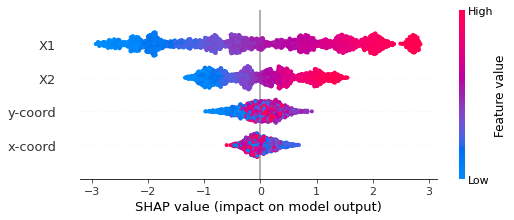

In [25]:
shap.summary_plot(shap_values,feature_names = names)

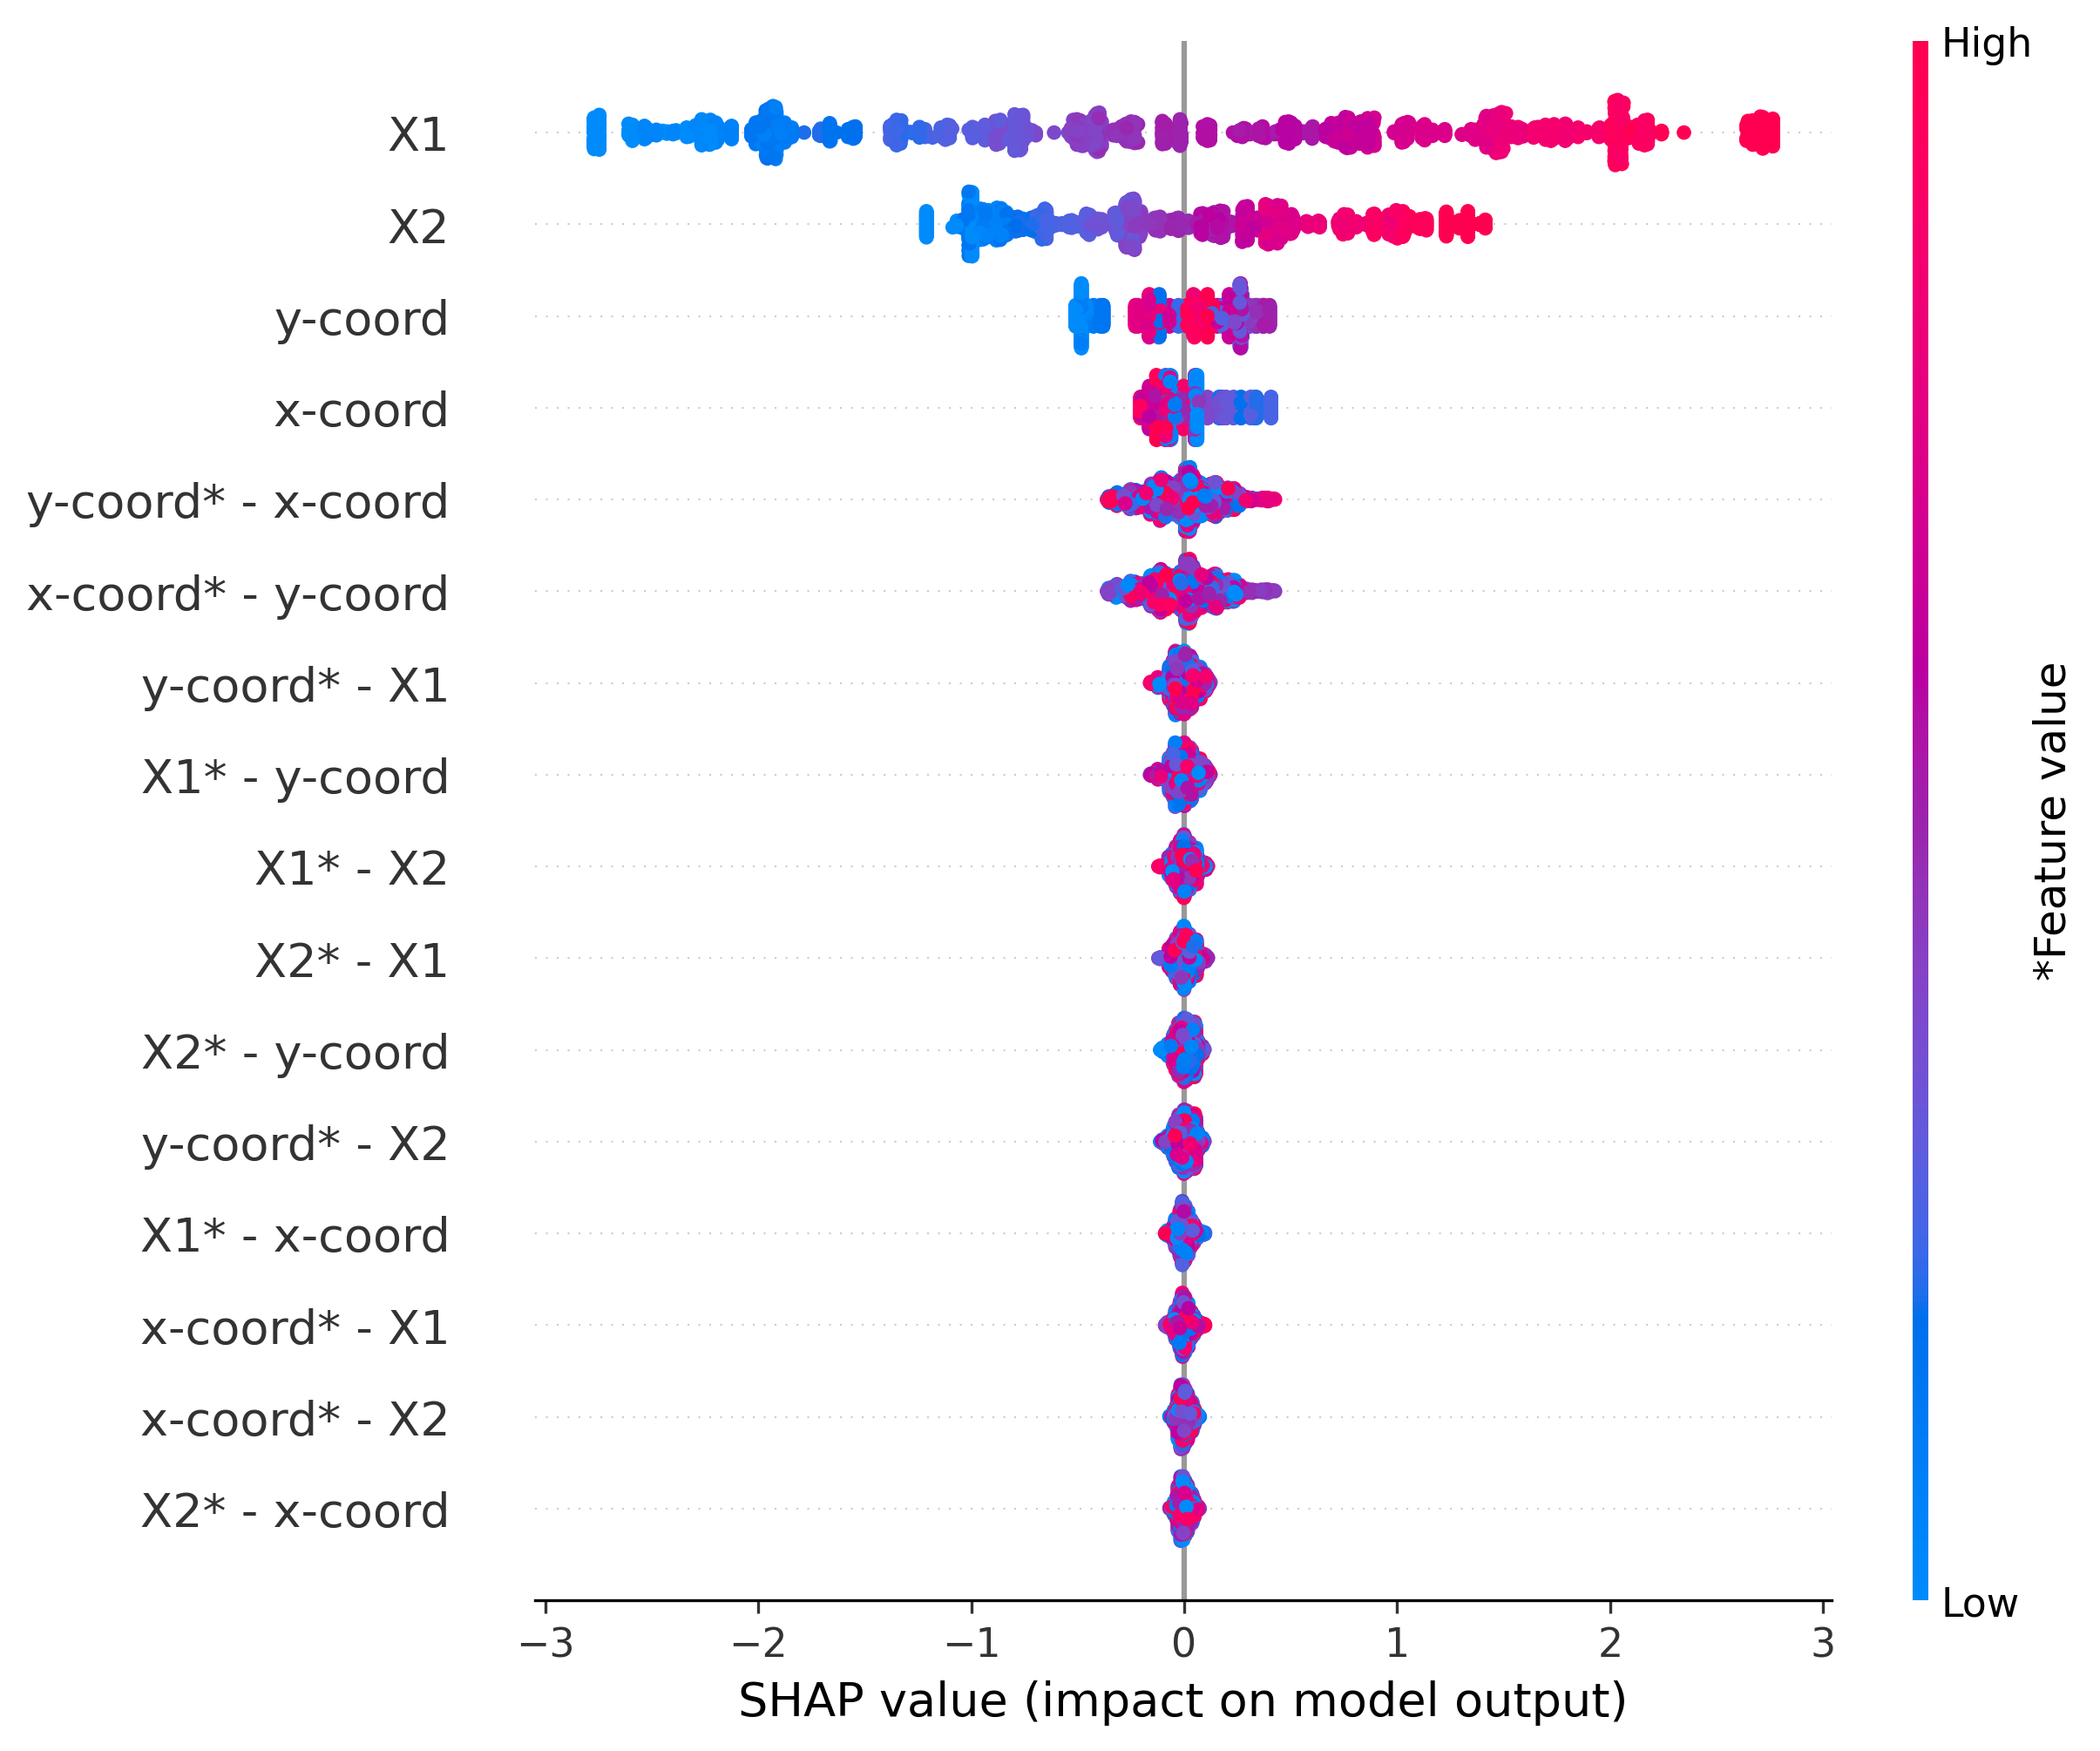

In [26]:
plt.figure(figsize=(12, 4), dpi=300)

shap_interaction_values = shap.TreeExplainer(final_model).shap_interaction_values(X_coords)

shap.summary_plot(shap_interaction_values, X_coords, 
                  feature_names = names,
                  plot_type="compact_dot")

In [27]:
f1_est = shap_values[:,0].values
f2_est = shap_values[:,1].values

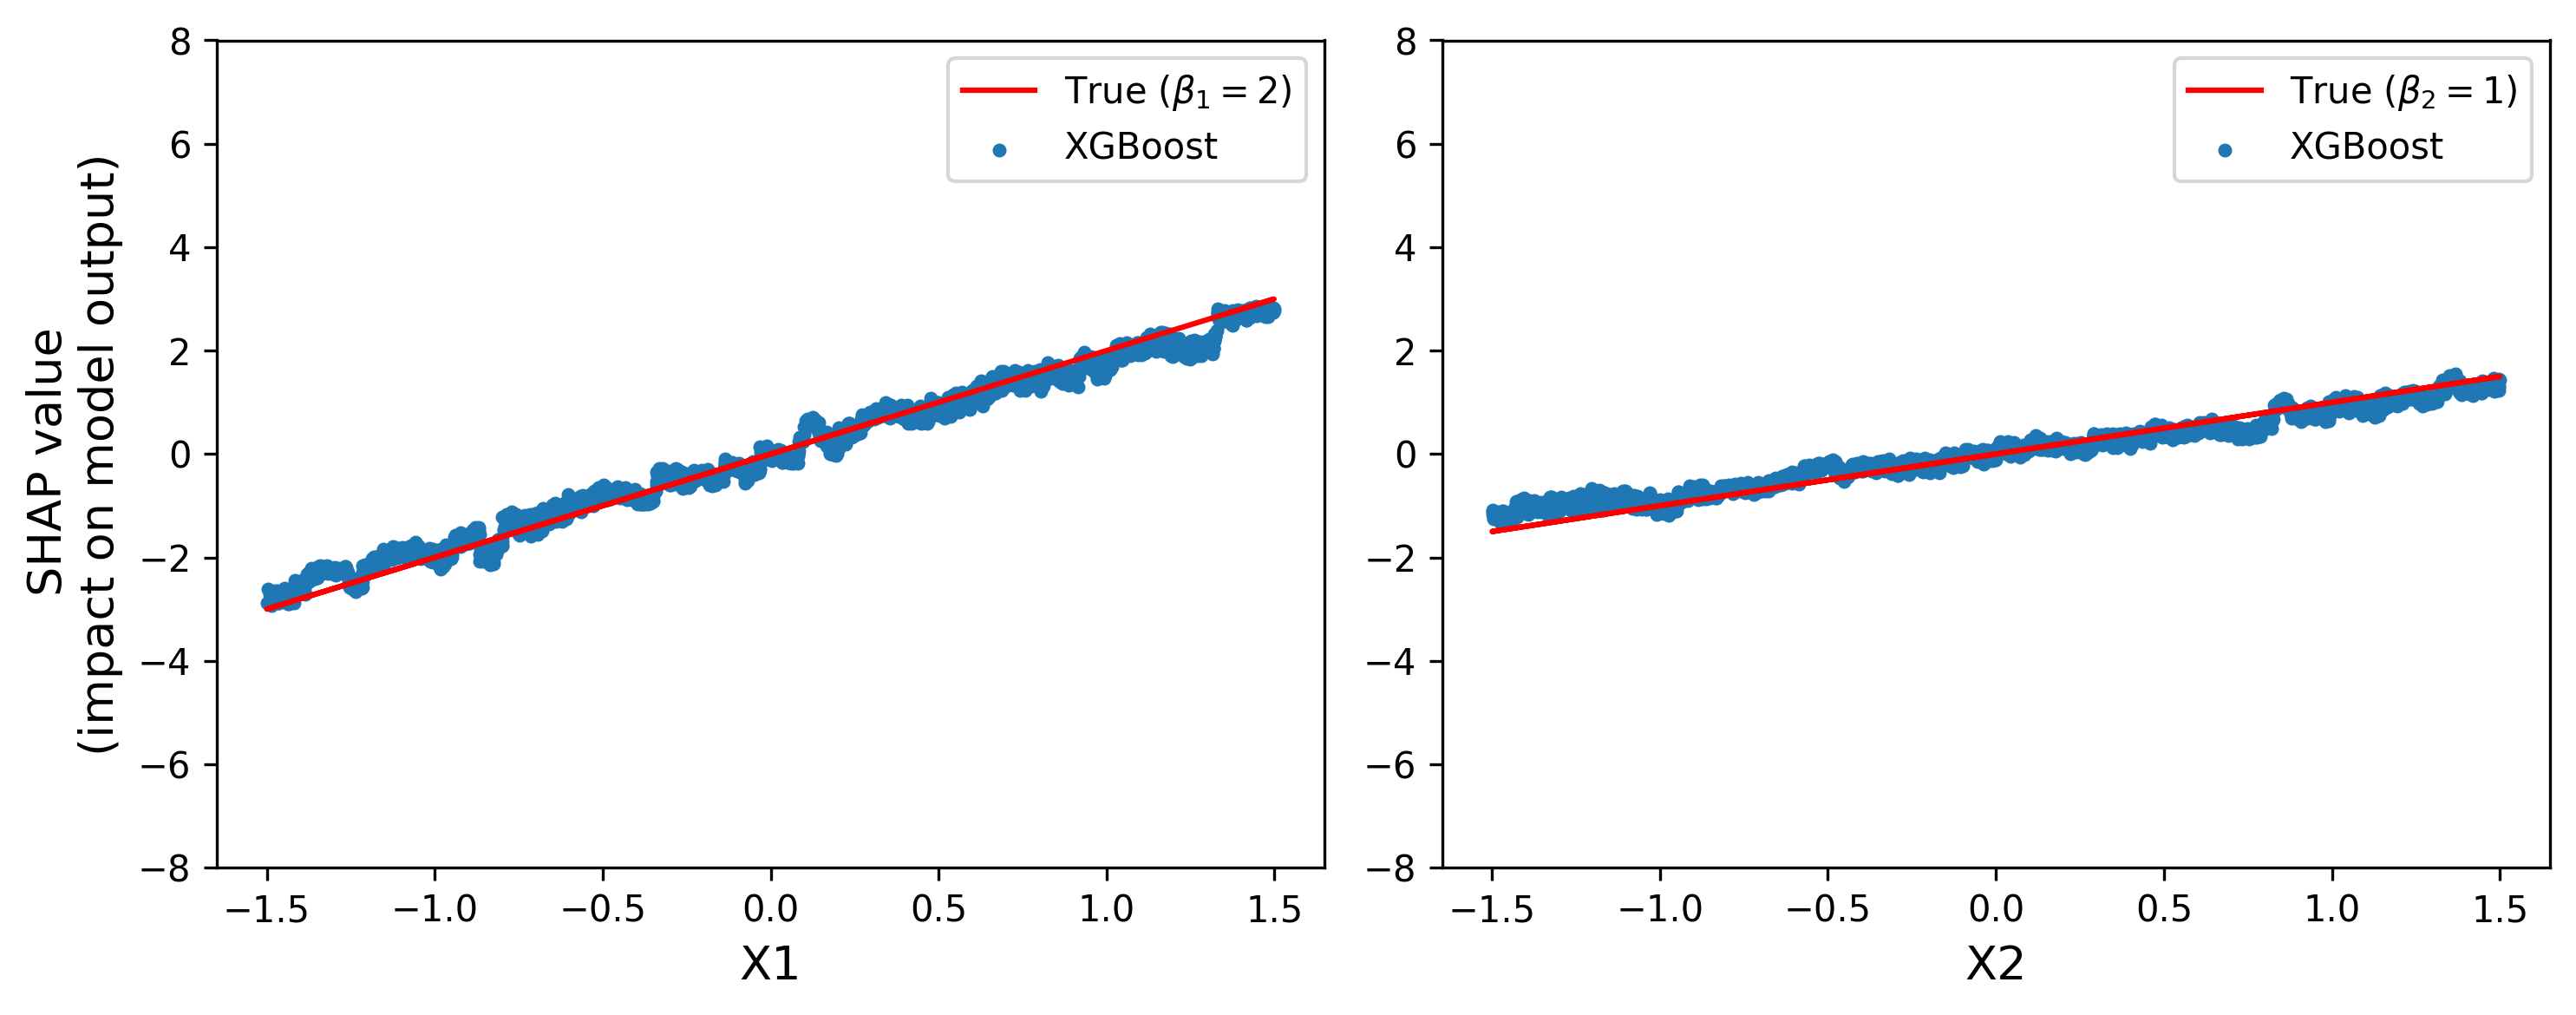

In [28]:
plt.figure(figsize=(10, 4), dpi=300)

plt.subplot(121)
plt.plot(shap_values[:,0].data,shap_values[:,0].data*b1, label=r"True ($\beta_1=2$)",color="red")
plt.scatter(shap_values[:,0].data,f1_est, label="XGBoost",s=8)

plt.xlabel("X1",fontsize=13)
plt.ylabel("SHAP value \n(impact on model output)",fontsize=13)
plt.ylim(-8,8)
plt.legend()

plt.subplot(122)
plt.plot(shap_values[:,1].data,shap_values[:,1].data*b2, label=r"True ($\beta_2=1$)",color="red")
plt.scatter(shap_values[:,1].data,f2_est, label="XGBoost",s=8)


plt.xlabel("X2",fontsize=13)
plt.ylim(-8,8)
plt.legend()

plt.tight_layout()

In [29]:
f0_est = y.mean() + shap_values.values[:,2:].sum(axis=1) 

In [30]:
y.mean()

0.04589695775878195

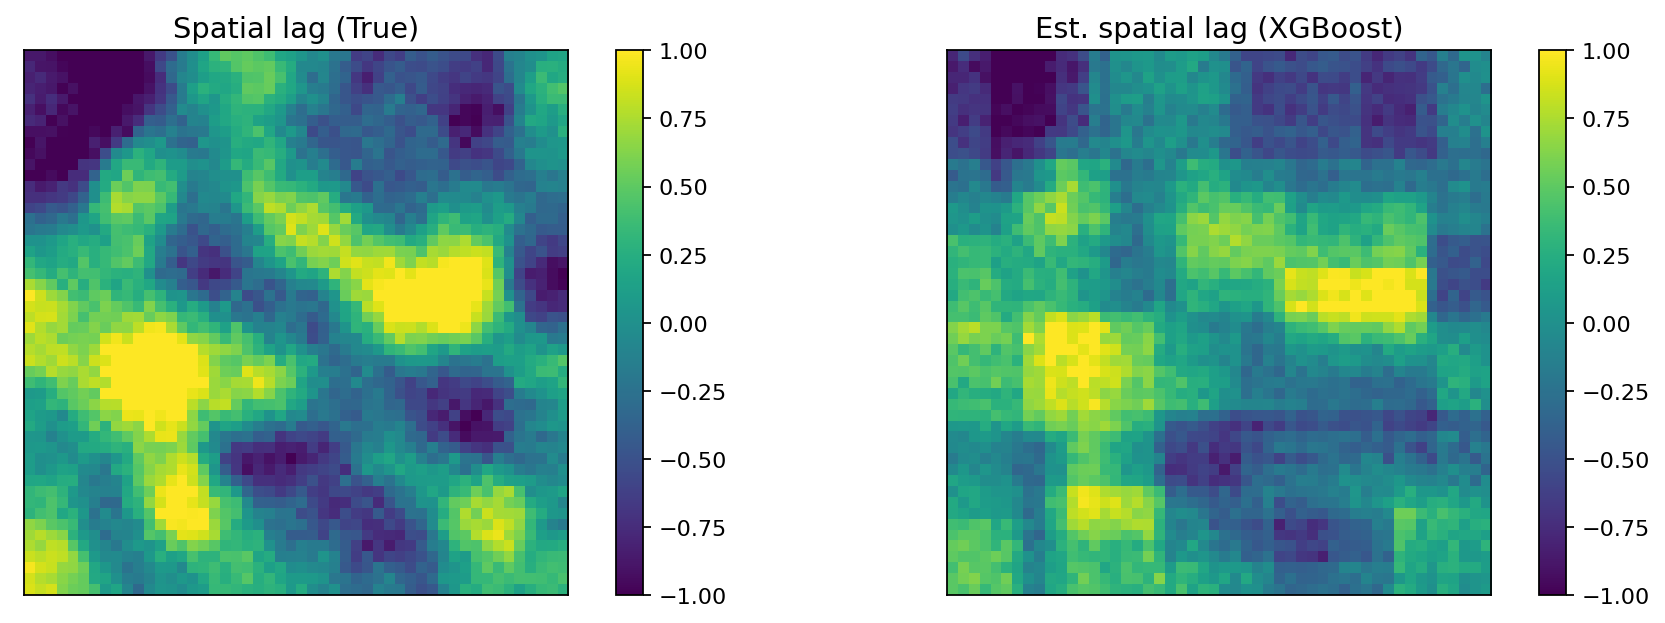

In [31]:
plt.figure(figsize=(12, 4), dpi=160)
plt.tight_layout()

plt.subplot(121)
rho_y = ro*w.full()[0].dot(y)
plot_1(rho_y, r'Spatial lag (True)',vmin=-1,vmax=1)

plt.subplot(122)
plot_1(f0_est-y.mean(),'Est. spatial lag (XGBoost)',vmin=-1,vmax=1)

plt.tight_layout()

In [32]:
print(np.sqrt(mean_squared_error(f0_est,rho_y)))
print(np.sqrt(mean_squared_error(slm.betas[-1][0]*w.full()[0].dot(y),rho_y)))

0.2721254369811985
0.01651893010105942


In [33]:
f1 = b1*X1
f2 = b2*X2

print(np.sqrt(mean_squared_error(f1_est,f1)))
print(np.sqrt(mean_squared_error(slm.betas[1][0]*X1,f1)))

0.21803951917286798
0.007457840927106849


In [34]:
print(np.sqrt(mean_squared_error(f2_est,f2)))
print(np.sqrt(mean_squared_error(slm.betas[2][0]*X2,f2)))

0.18713223670511425
0.011263346296282813


In [35]:
slm.betas[-1][0]

0.7766154922608007

In [36]:
w2 = KNN.from_dataframe(gdf,k=8)
w2.transform = 'R'
mi = Moran(y - y_pred, w2, permutations=999)

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


In [37]:
mi.I

0.05544182779313894

In [38]:
w2 = KNN.from_dataframe(gdf,k=8)
w2.transform = 'R'
mi = Moran(y - slm.predy.reshape(-1), w2, permutations=999)

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


In [39]:
mi.I

0.012522202802883447